In [1]:
import sys,os
# add the path to the library and load it
sys.path.insert(0, os.path.abspath("../../"))
from EPlink import Polymer_inference
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
np.random.seed(42)

# Downsampling posterior samples

The posterior samples needed for inference turns out to require quite fine temporal resolution. This leads to large datasets, which can be computationally expensive to work with. In this notebook, we will explore the idea of downsampling the posterior samples to reduce the computational cost of working with them.

## Why are the samples so big in the first place?
A key parameter of interest in the inference is the contact radius below which enhancer-promoter interaction lead to transcription. We therefore need to retain spatial information relevant to identification of this length scale. We shall assume that it lies in an interval above a certain minimal distance $r_\mathrm{min}$.


The minimal distance constrains the Rouse model and our sampling of it. The central assumptions we need to fulfil are 
1. The sampling must be fast enough to capture transits across the volume defined by $r_\mathrm{min}$.
2. The MSD is Rouse (not diffusive) for all $t$ and $r$ investigated.




The meaning of the first condition can be understood by considering the expression for the two-locus MSD in the Rouse model. We assume that we have chosen the bead size such that the MSD is Rouse for time-scales relevant for contact. For short times we then have 
$$
\mu(t) = 2*3*\Gamma*\sqrt{t}\,,
$$
where $\Gamma\equiv 2D\sqrt{\gamma/\pi k}$ is the Rouse diffusion constant. Inserting $\mu=r_\mathrm{min}^2$ and solving for $t$ we get the timescale
$$
\tau = \frac{r_\mathrm{min}^4}{36 \Gamma^2}\,.
$$
We need to be a few times lower than this to be on the safe side and therefore choose the sampling interval $\Delta t=\tau/10$. 

The second condition implies that the crossover from diffusive to Rouse behaviour must occur at our sampling interval $\Delta t$. The crossover can be found to be 
$$
\tau_\mathrm{diff->Rouse} = \frac{\gamma}{\pi k}\,.
$$
which immediately fixes the spring constant by inserting $\Delta t$ for $\tau_\mathrm{diff->Rouse}$ and solving for $k/\gamma$
$$
\frac{k}{\gamma} = \frac{1}{\pi \Delta t}=\frac{10}{\pi \tau} = \frac{360 \Gamma^2}{\pi r_\mathrm{min}^4}\,.
$$

We see that the anomalous diffusion constant $\Gamma$ is the only experimental parameter involved here. To get a sense for the values, we can use the approximate value of $\Gamma\approx 2000\, \mathrm{nm}^2/\sqrt{\mathrm{s}}$ (Michele et al. 2022) and $r_\mathrm{min}=30\, \mathrm{nm}$ in terms of which we get 
$$
\Delta t = \frac{(30\,\mathrm{nm})^4}{10*36*(2000\,\mathrm{nm}^2/\sqrt{\mathrm{s}})^2} = 0.6\,\mathrm{ms}\,.
$$
$$
\frac{\gamma}{k} = \pi \Delta t = 2\, \mathrm{ms}\,.
$$

This is a surprisingly small interval since normal framerates for these types of experiments are 1 per ~10 s for around 300 frames meaning that there are around 15,000 $∆t$ between images in the microscope and a whole recording is around 5,000,000 $\Delta t$! A single posterior sample will have three spatial dimensions, and with 4 bytes per float will take up 60Mb. Any computations on this data attempted on a GPU will necessarily lead to much larger memory requirements and we see that attempts to reduce this amount for downstream calculations will lead to large improvements in runtime. 

## Downsampling the posterior samples

To start thinking about downsampling, we consider what the downstream transcription process reads out from the posterior samples. A toy model of the  transcription process could be the equation 
$$
\cdot{m} = \alpha(t)-m\gamma\,,
$$
where $\gamma$ is a degradation rate and $m$ can be thought of as MS2 signal in a somewhat simplified fashion. The enhancer-promoter pair has the potential to generate transcription when they are closer than $r\mathrm{c}$. The relevant parameter from the posterior sample is therefore something akin to
$$
c(t) = \exp\left(-\frac{r(t)^2}{2r_\mathrm{c}^2}\right)\,,
$$
such that the growth rate becomes
$$
\alpha(t) = f(c(t))\,.
$$
We shall assume that $f$ doesn't smooth the signal much but either shifts it in time or leaves it constant. If this is the case, whatever timescale we had in $c(t)$ is carried through to $\alpha(t)$ and the problem of downsampling becomes that of figuring out which timescales $m(t)$ is sensitive to when driven by a signal $\alpha(t)$.

The solution for $m(t)$ is
$$
m(t) = \int_{-\infty}^t \alpha(t')\exp\left(-\gamma(t-t')\right)dt'\,.
$$
where we see that the signal $m(t)$ at time $t$ is a sum of past growth rates $\alpha(t')$ weighted by an exponential decay. The characteristic timescale for the weighted sum is $\gamma^{-1}$ and we can conceptually think of the signal as a low-pass filter where we average over the past $\gamma^{-1}$ seconds. We therefore don't expect to loose any information by averaging the posterior samples over this timescale.

How much do we stand to gain from this procedure? That all depends on the value of $\gamma$. But in general, we expect $\gamma$ to be comparable to the measurement timescale as this is the signal of interest. We can therefore expect to reduce the size of the posterior samples by a factor of roghly $1/\Delta t\gamma$ without affecting the inference. 

This is not a small number! Even if we assume that $1/\gamma$ is on the order of a second (around 10 to 20 times lower than the expected interval between microscopy images), we can reduce the size of the posterior samples by a factor 1000 by bin averaging.

### Example

To see how this works, lets take an example traces from the posterior samples and use them to drive our toy model. First we load a sample and compute the contact trace. We then coarse-grain it by averaging in blocks of size $1/\gamma$ and plot the result and plot it along with the original contact trace.

In [2]:
folder = "Data/"
o_times,samp_times = np.load(folder+"observation_times.npy"),np.load(folder+"simulation_times.npy")
True_traj,Traj_w_locerr,samples,fine_scale_traj = np.load(folder+f"ep_traj_0.npy"),np.load(folder+f"ep_traj_w_err_0.npy"),np.load(folder+f"Post_samps_0.npy"),np.load(folder+f"ep_traj_fine_0.npy")

In [3]:
rc = 30 #nm
gamma = 1/40 #1/s
dt_sample = samp_times[1]-samp_times[0]
n_gamma_to_sample = 10
sample_used_here = samples[0] # we'll ues the first sample

#the block size is the nearest integer (rounded down) to partition the data into blocks of equal size
avg_block_size= int((1/gamma/n_gamma_to_sample)/dt_sample)
sample_len = len(sample_used_here)
remainder = sample_len%avg_block_size

ep_distance = np.sqrt(np.sum(sample_used_here**2,axis=-1))
contact_trace = np.exp(-ep_distance**2/2/rc**2)
block_avg_contacts = np.mean(contact_trace[:sample_len-remainder].reshape(-1
,avg_block_size),axis=-1)
avg_times = samp_times[:sample_len-remainder].reshape(-1,avg_block_size).mean(axis=-1)

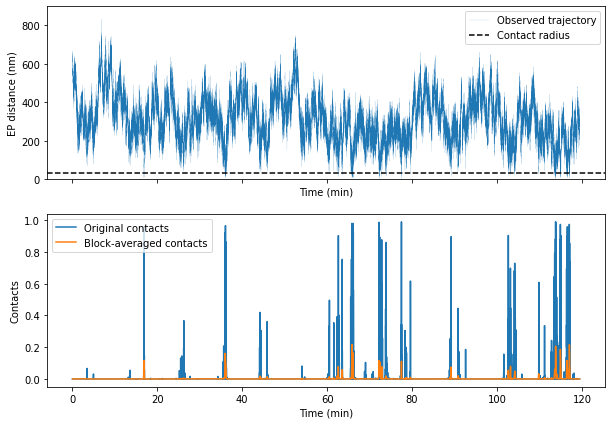

In [4]:


fig,ax = plt.subplots(2,1,figsize=(10,7),sharex=True)
ind_num = np.random.randint(len(samples))

ax[0].plot(samp_times/60,ep_distance,linewidth=.1,label="Observed trajectory")
ax[0].set(xlabel="Time (min)",ylabel="EP distance (nm)",ylim=(0,900))
ax[0].axhline(rc,linestyle="--",color="k",label="Contact radius")
ax[0].legend()

ax[1].plot(samp_times/60,contact_trace,label="Original contacts")
ax[1].plot(avg_times/60,block_avg_contacts,label="Block-averaged contacts")
ax[1].set(xlabel="Time (min)",ylabel="Contacts")
ax[1].legend()


It is interesting to note that the block-averaged trace generally has a lower value than the original trace. This is because most contacts are very brief, and therefore most of the values in the averaging region is zero. This is strongly dependent on the contact radius as it takes longer to pass across a larger contact region.

We can now use the contact trace to drive the transcription model, we do this by numerically integrating the model.

In [5]:
alpha = gamma*10
non_averaged_result = np.zeros_like(samp_times)
averaged_result = np.zeros_like(avg_times)

# integrate the trajectory using the full trace
for i in tqdm(list(range(1,len(samp_times)))):
    dt = samp_times[i]-samp_times[i-1]
    non_averaged_result[i] = non_averaged_result[i-1] + dt*(alpha*contact_trace[i-1] - gamma*non_averaged_result[i-1])
    
# integrate the trajectory using the block-averaged trace
for i in tqdm(list(range(1,len(avg_times)))):
    dt = avg_times[i]-avg_times[i-1]
    averaged_result[i] = averaged_result[i-1] + dt*(alpha*block_avg_contacts[i-1] - gamma*averaged_result[i-1])


100%|██████████| 1799/1799 [00:00<00:00, 1940229.60it/s]


[Text(0, 0.5, 'Deviation between\nblock avg and original'),
 Text(0.5, 0, 'Time (min)')]

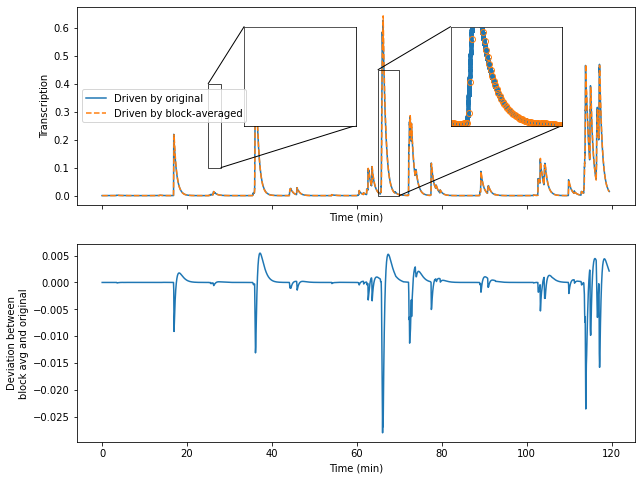

In [7]:
deviation = (non_averaged_result[:sample_len-remainder][::avg_block_size] - averaged_result)

fig,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
#plot the transcription
ax[0].plot(samp_times/60,non_averaged_result,label="Driven by original")
ax[0].plot(avg_times/60,averaged_result,linestyle="--",label="Driven by block-averaged")
ax[0].set(ylabel="Transcription",xlabel="Time (min)")
ax[0].legend()
# make inset between 25 and 28 minutes
inset = ax[0].inset_axes([0.3,0.4,0.2,0.5],xlim=(25,28),ylim=(0.1,0.4), xticks=[], yticks=[], xticklabels=[], yticklabels=[])
inset.plot(samp_times/60,non_averaged_result,".")
inset.plot(avg_times/60,averaged_result,"o",markerfacecolor="none")
inset.indicate_inset_zoom(inset)
box, c1 = ax[0].indicate_inset_zoom(inset, edgecolor="black", alpha=1,lw=0.7)
# make inset between 63 and 80 minutes
inset = ax[0].inset_axes([0.67,0.4,0.2,0.5],xlim=(65,70),ylim=(0,0.45), xticks=[], yticks=[], xticklabels=[], yticklabels=[])
inset.plot(samp_times/60,non_averaged_result,".")
inset.plot(avg_times/60,averaged_result,"o",markerfacecolor="none")
inset.indicate_inset_zoom(inset)
box, c1 = ax[0].indicate_inset_zoom(inset, edgecolor="black", alpha=1,lw=0.7)
#Plot deviation
ax[1].plot(avg_times/60,deviation)
ax[1].set(ylabel="Deviation between\nblock avg and original",xlabel="Time (min)")

As is hopefully evident, the results are almost indistinguishable despite the fact that the posterior trajectory has been down-sampled almost 1000 times! 

## Using the average contact trace to drive the transcription model